This notebook contains the code for the submission of the second project - Continuous Control - for the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

# Analysing the Environment

We begin by importing the necessary packages. The simulator provided for this project uses Unity.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple, deque
import time
import random
import copy
import pickle
import json

import matplotlib.pyplot as plt
%matplotlib inline

To support various hardware we also define a global variabe `device` that will indicate if the PyTorch should use GPU (if avaialable) or CPU. Later the model components will be deployed to this device.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

We have already done some testing and we concluded that using the 20-arms version of the simulator provides faster gathering of samples, which is crucial for the fast training of the model. We will therefore in this notebook work directly with this version of the emulator. The code is written that you can switch between the simulators without needing to change anything els, but the single arm simulator will be significantly slower to train.

In [3]:
#env = UnityEnvironment(file_name='Reacher(1).app')
env = UnityEnvironment(file_name='Reacher(20).app')
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
print('Number of brains: {}'.format(len(env.brain_names)))
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]
print(brain)

Number of brains: 1
ReacherBrain
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('State space shape: {}'.format(states.shape))

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
State space shape: (20, 33)


## Take Random Actions in the Environment

In the next code cell, we exemplify how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.

In [6]:
def random_episode(env, brain_name, train_mode=False):
    # reset the environment
    env_info = env.reset(train_mode)[brain_name]
    # get the current state (for each agent)
    states = env_info.vector_observations                  
    # initialize local vars
    scores = np.zeros(num_agents)
    steps = 0
    episode = []
    while True:
        # select a random action (for each agent) and clip
        actions = np.random.randn(num_agents, action_size)
        actions = np.clip(actions, -1, 1)
        # send all actions to the environment
        env_info = env.step(actions)[brain_name]
        # get next states, rewards and check if done
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        # update scores
        scores += env_info.rewards
        episode.append((states, actions, rewards, next_states, dones))
        # roll over states to next time step
        states = next_states
        steps += 1
        if np.any(dones):
            # exit loop if episode finished
            break

    if not train_mode:
        print('Scores: ', scores)
        print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
        print('Number of steps: {}'.format(steps))
    else:
        return scores, episode

In [7]:
#random_episode(env, brain_name, train_mode=False)

During the play we could see from time to time (relatively rarely) the target zone changing colour to green, a sign that the arm has reached the goal area.

Also it is possible to see that that an episode ends after 1001 steps.

# DDPG Model

The DDPG was introduced by T.P.Lillicrap in a [paper](https://arxiv.org/abs/1509.02971) published in 2015.

Some of the characteristics of the model are:
- uses one network for **actor** that maps states to actions using a deterministic approach (this makes it suitable for continuous control where the output actions are in continuous space)
- uses another network **the critic** to evaluate the Q function of the state and (chosen) action of the actor
- for both actor and critic we use a **local / target copy**, similar to DQN model that allows us to reduce the variance in training and improve convergence
- updates from local to target networks are using a **"soft update"** approach
- since we are using off-policy methods we can use **Replay Buffer** to store the expriences and train from a random sample, thus reducing the bias

## Model

Let us first start with the model of our netwroks that will be used. We will have a NN that will play the role of the **Actor** and will need to map the states to the actions and we will need a NN for the **critic** that will receive a state *and* an action and will provide a Q value.

### The Actor

The actor network will simply have an imput a state and will output the action for that state. We have used the same architecture as suggested in the [ddpg-pendulum](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum):

- we use fully connected NN layers (we do not process images so no need for CNNs)
- the inner hidden layers will use ReLU activation functions
- since the output will have to be an action (vector) in the range -1, 1 we will use a `tanh` activation function that will produce exactly this
- for optimization we will initialize the weights of the hidden layers using a random distribution in a range given by $$-{1 \over \sqrt{size_{imp}}}, {1 \over \sqrt{size_{imp}}}$$ where $size_{imp}$ is the input size of the layer
- the last layer is initialized using very small random values

In [8]:
def hidden_init(layer):
    """Calculates the initialization parameters for the hidden layers
    """
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

To be able to experiment with different structures for the neural nets we will define the Actor and the Critic networks with a coinfigurable parameter that indicates the sizes of the hidden layers.

In [9]:
class Actor(nn.Module):
    """Actor (Policy) Model.
    
    Based on the code from ddpg-pendulum.
    """

    def __init__(self, state_size, action_size, seed, fc_units):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_units (list int): Number of nodes in the hidden layers
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        units = [state_size] + fc_units + [action_size]
        layers = []
        for i in range(len(units)-2):
            layer = nn.Linear(units[i], units[i+1])
            layer.weight.data.uniform_(*hidden_init(layer))
            layers.append(layer)
            layers.append(nn.ReLU())
        # last layer: different activation and initialization
        layer = nn.Linear(units[-2], units[-1])
        layer.weight.data.uniform_(-3e-3, 3e-3)
        layers.append(layer)
        layers.append(nn.Tanh())
        self.net = nn.ModuleList(layers)

        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = state
        for layer in self.net:
            x = layer(x)
        return x

Let's see how that looks like for our case with the `state_size` and `action_size` as reported by the environment:

In [10]:
actor = Actor(state_size, action_size, seed=42, fc_units=[128, 128])
actor

Actor(
  (net): ModuleList(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
    (5): Tanh()
  )
)

In [11]:
# and one more:
actor = Actor(state_size, action_size, seed=42, fc_units=[512, 256, 128])
actor

Actor(
  (net): ModuleList(
    (0): Linear(in_features=33, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
    (7): Tanh()
  )
)

### The Critic

The NN for critic uses as inputs the state and the action (it will be the action that was taken by the actor) and outputs a Q value. As suggested in the original ddpg-pendulum code this NN will:

- we use fully connected NN layers (we do not process images so no need for CNNs)
- the inner hidden layers will use ReLU activation functions
- the last layer will have no activation function (we want to have any values calculated for the Q function)
- we will use the first set of hidden layers to process only the state input, then concatenante this last layer's output to the action input and use that as an input to the second set of hidden layers
- the initializations for the wieghts in the hidden layers uses the same method as for Actor
- the last layer is initialized with small values, similar to Actor

In [12]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc_units):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_units (list of 2 list of int): Number of nodes in the hidden layers:
                    there should be 2 lists, one for the nodes in the layer stack
                    that processes the state input and one stack that processes
                    the concatenated result of first stack and the actions
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # state layer stack
        state_units = [state_size] + fc_units[0]
        state_layers = []
        for i in range(len(state_units)-1):
            layer = nn.Linear(state_units[i], state_units[i+1])
            layer.weight.data.uniform_(*hidden_init(layer))
            state_layers.append(layer)
            state_layers.append(nn.ReLU())
        self.state_layers = nn.ModuleList(state_layers)
            
        # action layer stack
        action_units = [action_size + fc_units[0][-1]] + fc_units[1] + [1]
        action_layers = []
        for i in range(len(action_units)-2):
            layer = nn.Linear(action_units[i], action_units[i+1])
            layer.weight.data.uniform_(*hidden_init(layer))
            action_layers.append(layer)
            action_layers.append(nn.ReLU())
        # last layer: no activation, different initialization
        layer = nn.Linear(action_units[-2], action_units[-1])
        layer.weight.data.uniform_(-3e-3, 3e-3)
        action_layers.append(layer)
        self.action_layers = nn.ModuleList(action_layers)


    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = state
        for layer in self.state_layers:
            xs = layer(xs)
        x = torch.cat((xs, action), dim=1)
        for layer in self.action_layers:
            x = layer(x)
        return x

And this is how it looks like for our case with the state_size and action_size as reported by the environment:

In [13]:
critic = Critic(state_size, action_size, seed=42, fc_units=[[256], [256,128]])
critic

Critic(
  (state_layers): ModuleList(
    (0): Linear(in_features=33, out_features=256, bias=True)
    (1): ReLU()
  )
  (action_layers): ModuleList(
    (0): Linear(in_features=260, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

### The DDPG Net

Now that we defined the nets for the Actor and Critic we could define our agent that uses a 'local' and a 'target' version for each of these nets. Because we will have to save the weights of the networks so that we can use them after training we will introduce one more class: the `DDPGNet` that will combine the two networks so that we can save all the weights in one single file with one single call to `torch.save`. We also introduce a mothod `soft_update` that will be used by the actor to update the weights of the target networks from the local networks.

In [14]:
class DDPGNet(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, 
                 actor_units, critic_units):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            actor_units (list int): the number of nodes in the hidden layers
                    for the actor networks
            fc_units (list of 2 list of int): Number of nodes in the hidden layers:
                    there should be 2 lists, one for the nodes in the layer stack
                    that processes the state input and one stack that processes
                    the concatenated result of first stack and the actions
        """
        super(DDPGNet, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # actor nets
        self.actor_local = Actor(state_size, action_size, seed, actor_units)
        self.actor_target = Actor(state_size, action_size, seed, actor_units)
        # copy weights so that the networks start the same
        self.soft_update(self.actor_local, self.actor_target, 1)
        
        self.critic_local = Critic(state_size, action_size, seed, critic_units)
        self.critic_target = Critic(state_size, action_size, seed, critic_units)
        self.soft_update(self.critic_local, self.critic_target, 1)

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

            
    def actor_soft_update(self, tau):
        """Convenience method. Updates the actor's target net weight"""
        self.soft_update(self.actor_local, self.actor_target, tau)

        
    def critic_soft_update(self, tau):
        """Convenience method. Updates the critic's target net weight"""
        self.soft_update(self.critic_local, self.critic_target, tau)

        
    def forward(self):
        # we actually cannot use the net directly, we will need to use
        # the individual components
        pass

We can now use this net like this:

In [15]:
ddpgnet = DDPGNet(state_size, action_size, seed=0,
                  actor_units=[256,128,64],
                  critic_units = [[256, 128], [128, 64, 32]])
ddpgnet

DDPGNet(
  (actor_local): Actor(
    (net): ModuleList(
      (0): Linear(in_features=33, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=4, bias=True)
      (7): Tanh()
    )
  )
  (actor_target): Actor(
    (net): ModuleList(
      (0): Linear(in_features=33, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=4, bias=True)
      (7): Tanh()
    )
  )
  (critic_local): Critic(
    (state_layers): ModuleList(
      (0): Linear(in_features=33, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
    )
   

And we can now save it in one single file:

In [16]:
torch.save(ddpgnet.state_dict(), 'models/test_save.dat')

And we can now load it back:

In [17]:
ddpgnet.load_state_dict(torch.load('models/test_save.dat'))

## The Agent

Now that we have the NN that we need for the actor and critic parts we will start modelling the Agent. As mentioned earlier, this agent will use a Replay Buffer to store the experiences. Also, to allow exploration the DDPG model uses noise that is added to the action vector.

### Sweet Memories

We will first define a class that will be used to manage the experiences collected by the agent. We will use a Python `deque` of a size that is provided in the constructor `buffer_size`.

The class supports adding a new sequence of (state, action, reward, next_state, done) into the replay buffer (removing automatomatically the oldest ones if the buffer has reached it's max), and we also implement a convenience method that returns a sample (of a size provided in the constructor) from the buffer, already prepared as tensors.

In [18]:
Experience = namedtuple("Experience", 
                        field_names=["score", 
                                     "state", 
                                     "action", 
                                     "reward", 
                                     "next_state", 
                                     "done"])

In [19]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, seed=0):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
        """
        #self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.seed = random.seed(seed)
        self.episode = []

        
    def add_step(self, states, actions, rewards, next_states, dones):
        """Add a new experience to memory.
        The statem actions, etc. are all provided as list representing
        the values for each agent.
        If you are running the model with the one arm simulator, the
        parameters will still be lists of size 1."""
        step = []
        for (state, action, reward, 
             next_state, done) in zip(states, actions, rewards, 
                                      next_states, dones):
            e = Experience(0.0, state, action, reward, next_state, done)
            step.append(e)
        self.episode.append(step)
        
        
    def memorize(self):
        """The episode is added to the memory
        """
        scores = np.sum([[exp.reward for exp in step] for step in self.episode], axis=0)
        for step in self.episode:
            for agent, e in enumerate(step):
                # tupples are immuatable; need to create another experience
                # to update the score
                new_e = Experience(scores[agent], 
                                   e.state, 
                                   e.action, 
                                   e.reward, 
                                   e.next_state, 
                                   e.done)
                self.memory.append(new_e)            
        self.episode = []


    def random_fill(self, env, brain_name, n_entries):
        """Interact randomly with an environment and fill the memory
        """
        while len(self.memory) < n_entries:
            # call one episode in the environment
            scores, episode = random_episode(env, brain_name, train_mode=True)
            for (states, actions, rewards, next_states, dones) in episode:
                self.add_step(states, actions, rewards, next_states, dones)
            self.memorize()
            print('memory size: {}'.format(len(self.memory)))
            
        
    def experiences_to_tensor(self, experiences, device):
        """Converts numpy experience into tensors
        """
        states = torch.from_numpy(np.vstack([e.state for e in experiences \
                            if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences \
                            if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences \
                            if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences \
                            if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences \
                            if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    

    def sample_random(self, batch_size, device='cpu'):
        """Randomly sample a batch of experiences from memory."""
        indexes = np.random.choice(np.arange(len(self.memory)), 
                                   size=batch_size)
        experiences = [self.memory[index] for index in indexes]
        return self.experiences_to_tensor(experiences, device)
    
    
    def sample_prio_by_score(self, batch_size, device='cpu'):
        """Samples based on the scores"""
        distribution = [exp.score for exp in self.memory]
        distribution /= np.sum(distribution)
        indexes = np.random.choice(np.arange(len(self.memory)), 
                                   size=batch_size,
                                   p=distribution)
        experiences = [self.memory[index] for index in indexes]
        return self.experiences_to_tensor(experiences, device)
        
    
    def sample_prio_by_reward(self, batch_size, device='cpu'):
        """Samples based on the scores"""
        distribution = [exp.reward for exp in self.memory]
        distribution /= np.sum(distribution)
        indexes = np.random.choice(np.arange(len(self.memory)), 
                                   size=batch_size,
                                   p=distribution)
        experiences = [self.memory[index] for index in indexes]
        return self.experiences_to_tensor(experiences, device)
        
    

    def save(self, filename):
        f = open(filename, 'wb')
        pickle.dump(self.memory, f)
        f.close()
    
    
    def load(self, filename):
        f = open(filename, 'rb')
        self.memory = pickle.load(f)
        f.close()

    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Let's see how this works. Let's create a buffer with 100,000 experiences:

In [20]:
buffer = ReplayBuffer(100000)

In [21]:
#buffer.random_fill(env=env, brain_name=brain_name, n_entries=100000)
#buffer.save('memory/test.save.dat')
#print('max score: {}'.format(np.max([exp.score for exp in buffer.memory])))
#print('avg score: {}'.format(np.average([exp.score for exp in buffer.memory])))

The cell above has been run once to generate the dump but then was commented so that it will be skipped next time when the notebook is run. The result of the execution was (it will disspear from the output of the cell above once the notebook is run):

```
max score: 1.3599999696016312
avg score: 0.13617519695624708
```

If you want to generate another save, uncomment the lines and execute them.

Let us check that we can load the information from the disk. We will load that `test_save.dat` dump and recheck that the max and average scores are the same:

In [22]:
buffer.load('memory/test.save.dat')
print('max score: {}'.format(np.max([exp.score for exp in buffer.memory])))
print('avg score: {}'.format(np.average([exp.score for exp in buffer.memory])))

max score: 1.3599999696016312
avg score: 0.13617519695624708


Great, seems to be working fine. We will generate some dumps as needed and repeateadly use it when starting a training session so that we don't need to wait for the memory to be filled before we start training our model.

Let us see how the sampling works. First a random sample (each sample has equal probablity), and we will use a larger sample size so that we can compare better the 3 sampling options:

In [23]:
samp = buffer.sample_random(batch_size=256)[2]
print('num samples: {:d}'.format(samp.shape[0]))
print('max score:   {:.3f}'.format(torch.max(samp).item()))
print('avg score:   {:.3f}'.format(torch.mean(samp).item()))

num samples: 256
max score:   0.040
avg score:   0.000


We are showing only the rewards part of the sample. Since we have 100,000 samples and we are randomly selecting a small number from them, and since we have a 0.13 average score across all episodes, the vast majority of rewards are 0.0. So it is not unexpected to see that in the sample above.

Let's see if we select samples based on the overall episode total reward (score):

In [24]:
samp = buffer.sample_prio_by_score(batch_size=256)[2]
print('num samples: {:d}'.format(samp.shape[0]))
print('max score:   {:.3f}'.format(torch.max(samp).item()))
print('avg score:   {:.3f}'.format(torch.mean(samp).item()))

num samples: 256
max score:   0.040
avg score:   0.001


As expected, because we are prioritizing the episodes that had better scrores, we are getting an average marginally better (ultimately all steps in a given episode are labeled with the same score, so there will still be lots of steps with 0 reward that could be selected because the overall score that that episode was better). You can see that we also have a relatively good max score.

Now let's see what happens if we use the priority by reward sampling:

In [25]:
samp = buffer.sample_prio_by_reward(batch_size=256)[2]
print('num samples: {:d}'.format(samp.shape[0]))
print('max score:   {:.3f}'.format(torch.max(samp).item()))
print('avg score:   {:.3f}'.format(torch.mean(samp).item()))

num samples: 256
max score:   0.040
avg score:   0.039


You see that we might not have a very big difference in he max score (you might get different results based on how the data is really sampled, but in general the max score is very probably to be the same or close). On the other hand the average is very high compared to the previous other sampling methids, reflecting the bias of this sampling method towards selecting individual experiances with a high reward.

We will use later each of the sampling methods and study the impact they have on the convergence of the algorithm.

### Make Some Noise

In order to add noise to the actions determined by the Actor (remember that the NN that implements the Actor's fucntion is deterministic!) and thus allow for exploration the original implementation of DDPG used an [Ornstein-Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process) noise generator.

In [26]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

### Agent Implementation

Now we can define the agent. It will contain 4 networks:

- a 'local' network for the Actor
- a 'target' network for the Actor
- a 'local' network for the Critic
- a 'target' network for the Critic

These netowrks are created by the DDPGNet class. We include a replay buffer and an OU noise generator. The Agent also implements a soft update of the target networks.

The training for the **critic local network** is based on minimizing the MSE between a $Q_{expected}$ and a $Q_{target}$ in the current state. 

The $Q_{expected}$ for the current state is simply determined by passing the current state (*states*) and the current action (*actions*) from the batch to the **local critic network**.

The $Q_{target}$ for the current state is determined by adding the current reward (*rewards*) to the discounted $Q_{target \_ next}$, the Q function for the next state. This $Q_{target \_ next}$ can be computed by passing through the target critic network the next state (*next_states*) and the next actions.

To determine the next actions we will use the **target actor network** by passing it the next state (*next_states*).

We can then inovoke the optimizer for critic (local) and perform a backwards step starting from the loss. Since we need to calculate things in the inverse order they are listed above, the algorithm would look like this:
\begin{align*}
action_{next} &\Leftarrow \mathbf{target\_actor}(state_{next}) \\
Q\_target_{next} &\Leftarrow \mathbf{target\_critic}(state_{next}, action_{next}) \\
Q\_target &\Leftarrow reward + \gamma * Q\_target_{next} * (1 - done) \\
Q\_expected &\Leftarrow \mathbf{local\_critic}(state, action) \\
loss &\Leftarrow \mathbf{MSE}(Q\_expected, Q\_target)
\end{align*}

For the **local actor network** training we will use a loss that is based on the Q values calculated by the **target critic network** for the predicted actions produced by the local actor. Since the optimizer is minimizing the loss and we want to maximize the values produced by the target critic we will simply change the sign of the calculated Q values produced by the target critic and use that as a loss. And since we are calculating the Q values for a batch while the loss needs to be a scalar we will apply a `mean` calculation over the Q values.
\begin{align*}
action_{pred} &\Leftarrow \mathbf{local\_actor}(state) \\
loss &\Leftarrow -\mathbf{MEAN}(\mathbf{target\_critic}(state, action_{pred}))
\end{align*}

In [27]:
class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed,
                actor_units, critic_units,
                memory,
                batch_size,
                sampling,
                device,
                lr_actor=1e-4, lr_critic=1e-4,
                weight_decay=0,
                gamma=0.99,
                tau=1e-3,
                update_every = 10):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            actor_units (list int): configuration of layers for Actor nets
            critic_units (list list int): configuration of layers for Critic nets
            memory (ReplayBuffer): pre-created and loaded memory buffer to use
            batch_size (int): the size of the sampling from the replay buffer
            sampling (str): sampling method to use: 'random', 'score', 'reward'
            device (str): the hardware where the computation will happen
            lr_actor (float): learning rate for actor network
            lr_critic (float): learning rate for critic network
            weight_decay (float): weight decay for the critic optimizer
            gamma (float): discount factor for return
            tau (float): factor for soft update of target networks
            update_every (int): after how many steps we perform a training
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.actor_units = actor_units
        self.critic_units = critic_units
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        self.tau = tau
        self.steps = 0
        self.update_every = update_every   
              
        # setup the nets: one for each agent
        self.net = DDPGNet(state_size=state_size, action_size=action_size,
                           seed=random_seed,
                           actor_units=actor_units, critic_units=critic_units).to(device)
        self.actor_optimizer = optim.Adam(self.net.actor_local.parameters(), 
                                          lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.net.critic_local.parameters(),
                                           lr=lr_critic, 
                                           weight_decay=weight_decay)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = memory
        self.batch_size = batch_size
        self.sampling = sampling
        self.device = device

        
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward if reward > 0
        self.memory.add_step(states, actions, rewards, next_states, dones)

        # Learn, if enough samples are available in memory
        self.steps += 1
        if len(self.memory) > self.batch_size and self.steps % self.update_every == 0:
            self.learn()

            
    def act(self, states, eps, add_noise=True):
        """Returns actions for given state as per current policy
        for each agent.
        eps (float): a decay factor for application of noise
        """
        actions = []
        for state in states:
            state = torch.from_numpy(state).float().to(self.device)
            self.net.actor_local.eval()
            with torch.no_grad():
                action = self.net.actor_local(state).cpu().data.numpy()
            self.net.actor_local.train()
            if add_noise:
                action += eps * self.noise.sample()
            action = np.clip(action, -1, 1)
            actions.append(action)
        return np.array(actions)


    def reset(self):
        self.noise.reset()

        
    def learn(self):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        """
       
        for _ in range(num_agents):

            # draw samples
            if self.sampling == 'random':
                experiences = self.memory.sample_random(self.batch_size, 
                                                        self.device)
            elif self.sampling == 'score':
                experiences = self.memory.sample_prio_by_score(self.batch_size, 
                                                               self.device)
            elif self.sampling == 'reward':
                experiences = self.memory.sample_prio_by_reward(self.batch_size, 
                                                                self.device)
            # unpack experience
            states, actions, rewards, next_states, dones = experiences
            
            # ---------------------------- update critic ---------------------------- #
            # Get predicted next-state actions and Q values from target models
            actions_next = self.net.actor_target(next_states)
            Q_targets_next = self.net.critic_target(next_states, actions_next)
            # Compute Q targets for current states (y_i)
            Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
            # Compute critic loss
            Q_expected = self.net.critic_local(states, actions)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
            # Minimize the loss
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.net.critic_local.parameters(), 1)
            self.critic_optimizer.step()

            # ---------------------------- update actor ---------------------------- #
            # Compute actor loss
            actions_pred = self.net.actor_local(states)
            actor_loss = - self.net.critic_local(states, actions_pred).mean()
            # Minimize the loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # ----------------------- update target networks ----------------------- #
            self.net.critic_soft_update(self.tau)
            self.net.actor_soft_update(self.tau)                     

            
    def save(self, filename):
        """Save the model parameters.
        
        Params
        ======
            filename (str): file name including path
            
            The method will save the weights of all networks in the
            specified directory
        """
        torch.save(self.net.state_dict(), filename)
        
        
    def load(self, filename):
        """
        Loads the model parameters.
        All agents will be initialized to the same paramters as read from 
        the file.
        
        Params
        ======
            filename (str): file name including path
            
            The method will save the weights of all networks in the
            specified directory
        """
        self.net.load_state_dict(torch.load(filename))

## Trainer



In [28]:
def trainer(agent, n_episodes=1000, t_max=10800,
            print_every=None,
            save=True,
            eps_start=1.0, eps_min=0.05, eps_decay=0.99,
            threshold=30.0):
    """A help function that will handle the interaction with the environment
    and manage the agent.
    
    Params:
    ======
    agent (and Agent class): the agent that will be trained; the Agent
            must implement the methods `act`, `step` and `save`
    n_episodes (int): maximum number of episodes the trainer will run
    t_max (int): maximum duration to run the training is seconds
    save (Bool): saves the model with the best score
    eps_start, eps_min (float): parameters for noise
    eps_decay (float): dacay factor for applying noise
    threshold (float): the treshold for considering the problem solved
    """
    # print string for convenience
    print_str = '\rEpisode: {:4d} Score: {:.2f} Average: {:.2f} Memory: {:6d} Duration: {:.1f}s Running: {:.1f}s'

    # variable to store the results
    last_avg = 0
    scores_window = deque(maxlen=100)
    tot_dur = 0.0
    eps = eps_start
    
    # for saving things
    # run identification
    runID = time.strftime('%Y%m%d%H%M%S', time.localtime())
    print('runID:', runID)
    results_csv = 'results/' + runID + '.csv'
    results_info = 'results/' + runID + '.info'
    model_pth = 'models/' + runID + '.pth'
    model_info = 'models/' + runID + '.info'
    
    # write the info
    exclude = ['net', 'critic_optimizer', 'actor_optimizer', 
               'memory', 'noise', 'device']
    info = {k:v for (k,v) in agent.__dict__.items() if k not in exclude}
    with open(results_info, 'w') as f:
        json.dump(info, f)
    # write info for model
    with open(model_info, 'w') as f:
        json.dump(info, f)
    
    #writer = SummaryWriter()
    for i_episode in range(1, n_episodes+1):
        start = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)

        # run one episode
        while True:
            
            # determine action
            actions = agent.act(states, eps)
            
            # take the action; get the environment response
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # ask agent to process the results
            agent.step(states, actions, rewards, next_states, dones)

            # cumulate and move to next
            states = next_states
            scores += rewards
            if np.any(dones):
                # unless episode complete
                agent.memory.memorize()
                break
                
        # at the end of the episode keep track of time and scores
        duration = time.time() - start
        tot_dur += duration
        scores_window.append(np.mean(scores))
        avg = np.mean(scores_window)

        # print current numbers
        with open(results_csv,'a') as f:
            f.write('{:d},{:.5f},{:5f},{:5f}\n'.format(i_episode, 
                                np.mean(scores), avg, tot_dur))

        if print_every is not None and i_episode % print_every == 0:
            end = '\n'
        else:
            end = ''
        print(print_str.format(i_episode, np.mean(scores), avg, 
                len(agent.memory.memory), duration, tot_dur), end=end)

        if save and avg > last_avg:
            agent.save(model_pth)
            last_avg = avg

        # if solved
        if avg >= threshold:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\t In In {:.1f}s'\
                  .format(i_episode, avg, tot_dur))
            break
            
        if tot_dur > t_max:
            break
            
        eps = eps * eps_decay
        eps = max(eps, eps_min)

    # check if we finished all episodes but not found a solution
    if avg < threshold:
        print('\nFailed to converge in {:d} episodes.\tAverage Score: {:.2f}\t In {:.1f}'\
              .format(n_episodes, avg, tot_dur))

    # return results for analysis
    return runID

## Results

### Display support

We will define a supporting function that will display the desults of the training a matplot graph. We can pass to this function the list of run IDs that we want to display and to be able to distinguish the graph we indicate the measure that was relevant for that string of runs. The mothod will plot the scores and the 100-running average for each run indicating in the title the value of the measure used for that run. At the end we add a comparison of the running average for all runs by the episode number and one by time.

In [29]:
def plot_results(runIDs, measure):
    
    rows = (len(runIDs)+1) // 2 + 1
    fig = plt.figure(figsize=(12,rows*6))
    # for summary
    titles = []
    avgs = []
    episodes = []
    times = []
    lines = ['-', ':', '--']

    # inidividual runs
    for index, runID in enumerate(runIDs):
        data = []
        datafile = 'results/' + runID + '.csv'
        infofile = 'results/' + runID + '.info'
        with open(datafile) as f:
            for record in f:
                data.append(record[:-1].split(','))
        
        with open(infofile) as f:
            info = json.load(f)

        title = measure + ': ' + str(info[measure])
        titles.append(title)

        episode = [float(d[0]) for d in data]
        score = [float(d[1]) for d in data]
        avg = [float(d[2]) for d in data]
        time = [float(d[3])/60.0 for d in data]
        avgs.append(avg)
        episodes.append(episode)
        times.append(time)

        fig.add_subplot(rows, 2, index+1)
        plt.plot(episode, score)
        plt.plot(episode, avg, linewidth=3)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.title(title)
        maxy = max(avg)
        maxx = np.argmax(avg) + 1
        plt.annotate('max:\n{:.1f}'.format(maxy), 
                     xy=(maxx, maxy), xycoords='data',
                     xytext=(-10, 10), textcoords='offset pixels',
                     backgroundcolor='#d0d0d0',
                     horizontalalignment='center')
        plt.legend(['Max score: {:.1f} at {:d}'.format(max(score), np.argmax(score)+1),
                    'Max avg  : {:.1f} at {:d}'.format(maxy, maxx)],
                    loc='lower right')
    
    # final comparison
    fig.add_subplot(rows, 2, rows*2-1)
    for index, runID in enumerate(runIDs):
        plt.plot(episodes[index], avgs[index], linewidth=2, linestyle=lines[index%3])
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.legend(titles, loc='upper left')
        plt.title('Comparison by Episode#')

    fig.add_subplot(rows, 2, rows*2)
    for index, runID in enumerate(runIDs):
        plt.plot(times[index], avgs[index], linewidth=2, linestyle=lines[index%3])
        plt.ylabel('Score')
        plt.xlabel('Time [min]')
        plt.legend(titles, loc='upper left')
        plt.title('Comparison by Time')

    plt.show()

### `batch_size` impact

Let's first study the impact of the `batch_size`. We will run the training for 200 episodes for the following sizes: 16, 32, 64 and 128.

In [30]:
for batch_size in [16, 32, 64, 128]:
    # reload buffer for each run
    buffer.load('memory/test.save.dat')
    
    # create agent
    agent = DDPGAgent(state_size=state_size, 
                  action_size=action_size,
                  random_seed=1,
                  actor_units=[256,128],
                  critic_units=[[256],[256,128]],
                  memory=buffer,
                  batch_size=batch_size,
                  sampling='random',
                  device=device,
                  lr_actor=1e-4,
                  lr_critic=1e-4,
                  weight_decay=0,
                  gamma=0.99,
                  tau=1e-3,
                  update_every = 10)
    
    # train
    #trainer(agent, n_episodes=200)

The reported results for this were:

```
runID: 20181219124605
Episode:  200 Score: 3.47 Average: 2.46 Memory: 100000 Duration: 21.6s Running: 4282.9s
Failed to converge in 200 episodes.	Average Score: 2.46	 In 4282.9
runID: 20181219135729
Episode:  200 Score: 1.80 Average: 3.91 Memory: 100000 Duration: 21.2s Running: 4273.7s
Failed to converge in 200 episodes.	Average Score: 3.91	 In 4273.7
runID: 20181219150843
Episode:  200 Score: 27.77 Average: 18.76 Memory: 100000 Duration: 21.8s Running: 4383.9s
Failed to converge in 200 episodes.	Average Score: 18.76	 In 4383.9
runID: 20181219162149
Episode:  200 Score: 27.66 Average: 25.18 Memory: 100000 Duration: 21.5s Running: 4362.1s
Failed to converge in 200 episodes.	Average Score: 25.18	 In 4362.1
```

Let's display them:

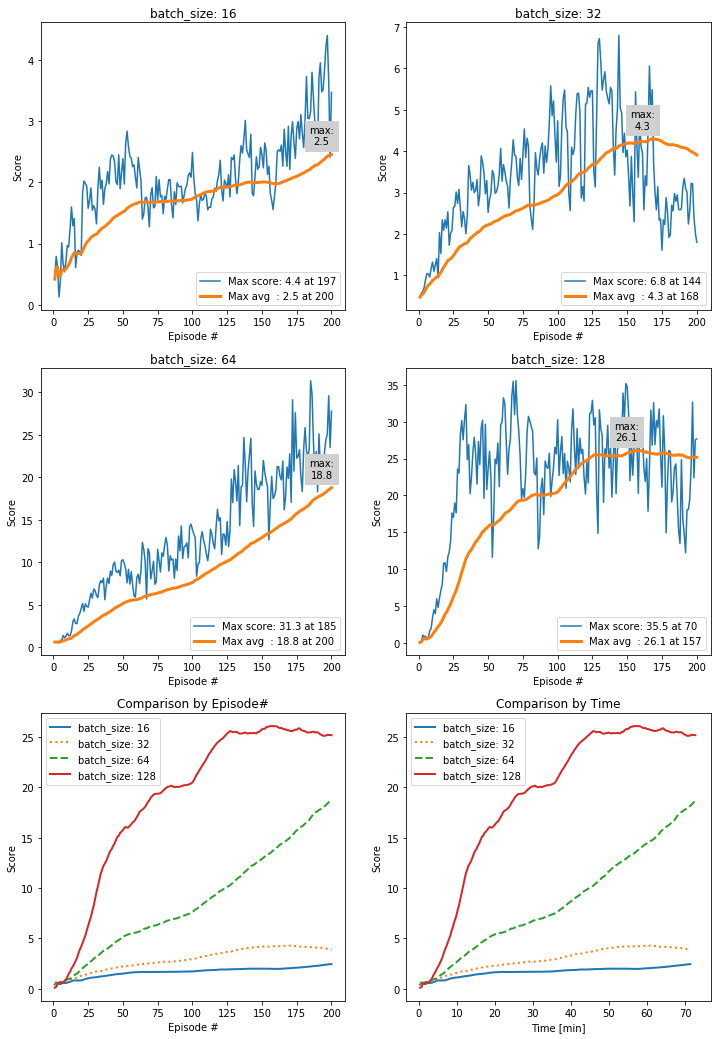

In [31]:
runIDs = ['20181219124605', '20181219135729', '20181219150843', '20181219162149']
plot_results(runIDs, 'batch_size')

Arguably the `batch_size` of 128 seems to be performing the best in these short runs. Although the running average was high, it failed to reach 30 and towards the end of training has flattended. We will have to find other paramters that we can tune to improve that result.

### `update_every` impact

Let us now see the impact of `update_every` parameter. In the previous runs we have used a value of 10, meaning that the agents are trained every 10 steps in the environment. This time we will try: 4, 8, 16 and 32 steps.

In the prvious section, using different `batch_size` did not affect the duration of the training. When changing the `update_every` parameter we would expect that to be different: the smaller the parameter, the more training runs are being executed, therefore the runs will take longer. To avoid wasting too much time, the paramter `t_max` of the `trainer` will limit the execution to 2 hours (7200 seconds). This means that the graphs will make more sense when compared on the time scale rather than on the episodes scale.

Given that the `batch_size` of 128 was the best performer we will use that for all the runs below.

In [32]:
for update_every in [4, 8, 16, 32]:

    # reload buffer for each run
    buffer.load('memory/test.save.dat')

    # create agent
    agent = DDPGAgent(state_size=state_size, 
                  action_size=action_size,
                  random_seed=1,
                  actor_units=[256,128],
                  critic_units=[[256],[256,128]],
                  memory=buffer,
                  batch_size=128,
                  sampling='random',
                  device=device,
                  lr_actor=1e-4,
                  lr_critic=1e-4,
                  weight_decay=0,
                  gamma=0.99,
                  tau=1e-3,
                  update_every = update_every)
    
    # train
    #trainer(agent, n_episodes=200, t_max=7200)

The reported results for this were:

```
runID: 20181219175018
Episode:  192 Score: 29.51 Average: 28.67 Memory: 100000 Duration: 36.7s Running: 7225.0s
Failed to converge in 200 episodes.	Average Score: 28.67	 In 7225.0
runID: 20181219195045
Episode:  200 Score: 27.13 Average: 25.91 Memory: 100000 Duration: 23.8s Running: 4836.7s
Failed to converge in 200 episodes.	Average Score: 25.91	 In 4836.7
runID: 20181219211124
Episode:  200 Score: 6.34 Average: 5.34 Memory: 100000 Duration: 17.7s Running: 3475.4s
Failed to converge in 200 episodes.	Average Score: 5.34	 In 3475.4
runID: 20181219220921
Episode:  200 Score: 20.42 Average: 13.30 Memory: 100000 Duration: 13.6s Running: 2775.1s
Failed to converge in 200 episodes.	Average Score: 13.30	 In 2775.1
```

Let's display them:

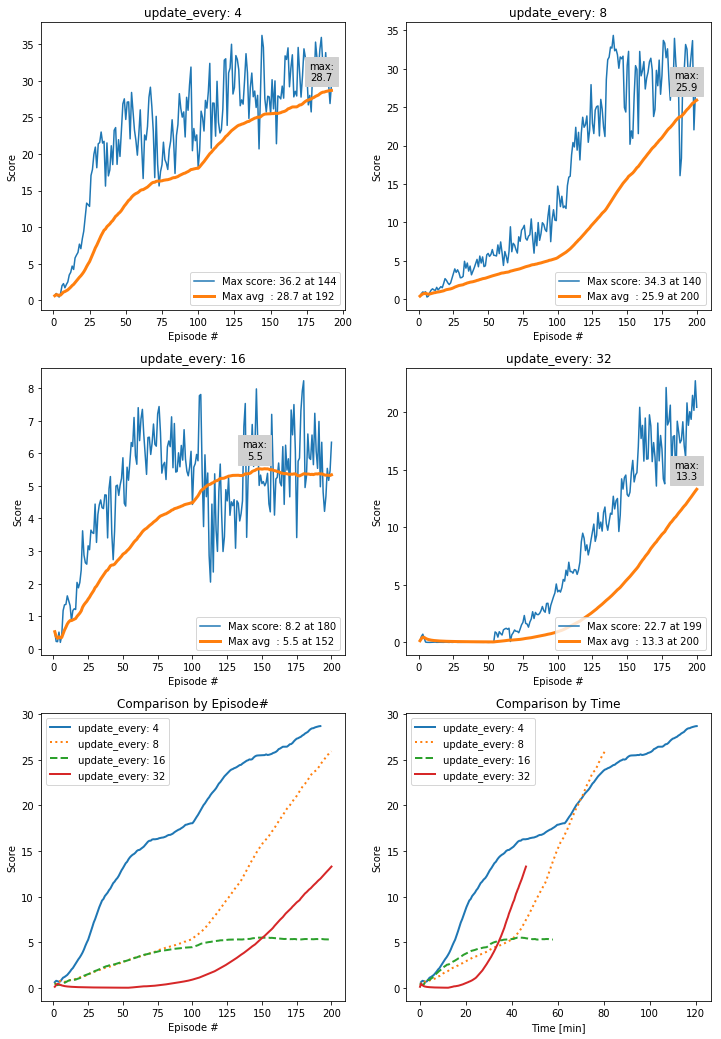

In [33]:
runIDs = ['20181219175018', '20181219195045', '20181219211124', '20181219220921']
plot_results(runIDs, 'update_every')

This is a very interesting result. We can see that using a lower `update_every` obtains a better score on a per Episode basis (see "Comparison by Episode#"), which is expected as we train more the networks for the same number of episodes. But this comes with a cost in terms of execution: more training means also more time spent for one episode. This is clearly visible on he "Comparison by Time" chart where. although all runs were done for 200 steps (almost - the first one runs only for 192 episodes as it runs out of time) you can clearly see how the run times increase almost linearly.

The first run, for `update_every` 4 scored the best average over 100 episodes until now, with a value of 28.7 and very posible it would have scored 30 if left to run past the 2 hours limit I set earlier.

But the run for `update_every` of 8 is signficantly more interesting. Although this run has scored a lower average of 25.9, it is significantly more promissing: the actual time is about 2/3 of the time taken by the first run (due to the reasons I explained earlier) and the trajectory of the average seems to be more linear with fewer fluctuations.

Even more, the last run, for `update_every` of 32, although it scored a mere 13.3 average, it did that is a very good time and overtook from that perspective the run with `update_every` of 8.

We will consider this value for the next evaluation.

### `sampling` impact

We will now check the impact of the way we sample from the replay memory. All runs up to now used `random` sampling. We wil run now the model with `score` and `reward` sampling, selecting experiancs from the buffer according to the probablity distribution produced by the overal episode score or the individual experience.

In [34]:
for sampling in ['random', 'score', 'reward']:

    # reload buffer for each run
    buffer.load('memory/test.save.dat')

    # create agent
    agent = DDPGAgent(state_size=state_size, 
                  action_size=action_size,
                  random_seed=1,
                  actor_units=[256,128],
                  critic_units=[[256],[256,128]],
                  memory=buffer,
                  batch_size=128,
                  sampling=sampling,
                  device=device,
                  lr_actor=1e-4,
                  lr_critic=1e-4,
                  weight_decay=0,
                  gamma=0.99,
                  tau=1e-3,
                  update_every = 32)
    
    # train
    #trainer(agent, n_episodes=500, t_max=10800)

The reported results for this were:

```
runID: 20181219231510
Episode:  145 Score: 35.79 Average: 30.05 Memory: 100000 Duration: 14.7s Running: 2190.5s
Environment solved in 145 episodes!	Average Score: 30.05	 In In 2190.5s
runID: 20181219235142
Episode:  126 Score: 36.90 Average: 30.31 Memory: 100000 Duration: 27.7s Running: 3583.4s
Environment solved in 126 episodes!	Average Score: 30.31	 In In 3583.4s
runID: 20181220005127
Episode:  465 Score: 0.36 Average: 1.10 Memory: 100000 Duration: 23.2s Running: 10803.8s
Failed to converge in 500 episodes.	Average Score: 1.10	 In 10803.8
```

Let's display them (I have also included in the first diagram the best performing run until now, the one that scorred 28.7):

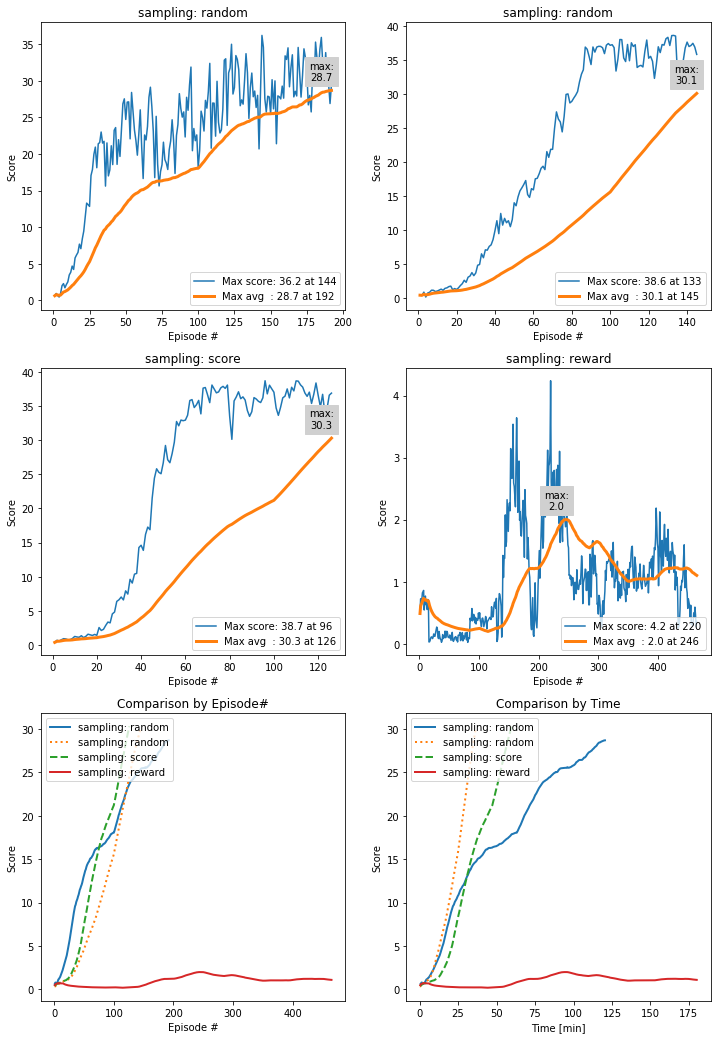

In [35]:
runIDs = ['20181219175018', '20181219231510', '20181219235142', '20181220005127']
plot_results(runIDs, 'sampling')

First, let us congratulate ourselves: two of the runs have scored above 30.0 over 100 episodes, so **we have solved the environment!**

Let us look at what happended. Let's start with the last run, that is based on a sampling of only those experiences that have a positive reward (**reward based samplig**). As much this might seem as a good idea (it might seem natural to think it would be better to learn from the "good" experiences), the reality is that the model failed to learn anything. Of course we could do a few more runs to confirm that this is not just a random occurance, but it seems to be backed but other reaserch too: bad experiences (where we receive a 0 reward) are as useful for learning as the ones we receive a reward. Knowing that a certain action is a bad one is still learning. The bias introduced by this sampling method is similar to growing up in sterile environment: the agent fails to learn to deal with the "real world".

Let us move to the run with **score based sampling**. Remember, this means we sample experiences from the replay memory based on the probablity distribution given by the overall episode score, with all experiences in that episode haveing the same weights. What this means is that we will be able to sample also experiences with 0 reward, just that they would be in the context of a better overall score. This seems to have more sense and we see that indeed the agent learns to solve the environment in 126 episodes, the quickest result. The drawback though is that the calculation of the sampling rates over a large memory buffer (100,000 experiances in our case) introduces a time penalty: on average the processing for one episode took roughtly double amout of time compared with the random sampling. Of course this could be probably optimized, as my current implementation did not focus too much on the performance of extracting the samples. There are several options possible:

- move the replay buffer in the GPU and use tensor math to do the distribution calculations
- since at the end of every episode we only add maximum 1001 experiences to the replay buffer, we don't need to re-calculate the distributions at every step. Instead we could re-calculate the distributions once every 10 episodes and use it for all the sampling during this time. At them moment we re-calculate the sampling even within the same step, when no changes are made to the replay buffer, because this is part of the methods in the ReplayBuffer class. Very inefficient indeed.

There will be a penalty for the additional calculation of the distributions for score-based sampling which will make the run longer, but there are situations where interation with the environment is more costly and takes longer where such an approach will perform better. The fact that this sampling method helped reducing the number of episodes from 145 to 126 (a 13% reduction) and this might be very important if the access to the environment is very very expesive.

Which brings us to the (current) winner: **the random sampling**. This managed to solve the environment in **145 steps** and in **just over 36 minutes**. 

## Further studies

There are a number of possible imediate further work with this model:

### Impact of the neural net structure

We have not studied the impact of the Actor and Critic NN structure. All runs used the default [256,128] for Actor and [[256], [256,128]] for Critic. It would be interesting to see if for this realively simple construct we might get better performance from a smaller network or a larget one. Also it would be interesting to study the realtionship between the networks: what happens when the Actor is very large and the Critic is small, or the other way around?

### Concatenate state vector

Similar to the strategy employed in the Atari games agent, we could concatenate 2-4 states from consecutive steps in an episode to produce a larger input state vector to the Actor and Critic. This would introduce some seqencing information in the input vector that would in principle improve the precitions procss, at the expense of a more complex network and training time. For this simple environment this might be an overkill (we already score very well with the current model), but it could be beneficial for more complex environments. 

### Improve algorithm for scores- and reward-based sampling

As indicated already in the text some of the degradation in peformance for th score-based sampling is due to a less than optimized approach in peforming this sampling. It would be realtively easy to update this algoriths to improve the performance of this sampling technique and thus speed up the run time when using this method.